In [ ]:
%pip install -q open_clip_torch h3 contextily

In [2]:
%%capture
%env AWS_REQUEST_PAYER=requester

---

In [164]:
from rastervision.core.box import Box
from rastervision.core.data import RasterioSource

from tqdm.auto import tqdm
import numpy as np
import torch
from torch.nn import functional as F
import geopandas as gpd
import h3
import contextily as cx
from matplotlib import pyplot as plt
from matplotlib import patches
import seaborn as sns
sns.reset_defaults()

---

## Load embeddings

In [4]:
# !aws s3 cp s3://raster-vision-ahassan/naip/skyscript_naip_MA_400_400.pt .
# !aws s3 cp s3://raster-vision-ahassan/naip/skyscript_naip_MA_800_800.pt .
# !aws s3 cp s3://raster-vision-ahassan/naip/skyscript_naip_MA_1600_1600.pt .

In [5]:
embs_400 = torch.load('data/skyscript_naip_MA_400_400.pt')
# embs_800 = torch.load('skyscript_naip_MA_800_800.pt')
# embs_1600 = torch.load('skyscript_naip_MA_1600_1600.pt')
embs_400.shape,  #embs_800.shape, #embs_1600.shape

(torch.Size([563379, 768]),)

---

## Load chip windows

In [4]:
# !aws s3 cp s3://raster-vision-ahassan/naip/naip_MA_400_400_w_uris.json .
# !aws s3 cp s3://raster-vision-ahassan/naip/naip_MA_800_800_w_uris.json .
# !aws s3 cp s3://raster-vision-ahassan/naip/naip_MA_1600_1600_w_uris.json .

In [6]:
windows_df_400 = gpd.read_file('data/naip_MA_400_400_w_uris.json')
# windows_df_800 = gpd.read_file('naip_MA_800_800_w_uris.json')
# windows_df_1600 = gpd.read_file('naip_MA_1600_1600_w_uris.json')

---

## Load model

In [7]:
import open_clip

model_name = 'ViT-L-14'
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

print('#params: ', f'{sum(p.numel() for p in model.parameters()):,}')

INFO:root:Loaded ViT-L-14 model config.


#params:  427,616,513


In [8]:
ckpt_path = 'data/SkyCLIP_ViT_L14_top50pct/epoch_20.pt'
ckpt = torch.load(ckpt_path, map_location='cpu')['state_dict']
ckpt = {k[len('module.'):]: v for k, v in ckpt.items()}
message = model.load_state_dict(ckpt)
model = model.eval()

---

# Land cover map from chip embeddings and chip geometries

In [13]:
def get_text_emb(text_queries):
    with torch.inference_mode():
        text = tokenizer(text_queries)
        text_emb = model.encode_text(text)
        text_emb /= text_emb.norm(dim=-1, keepdim=True)
        text_emb = text_emb.cpu()
    return text_emb

In [61]:
classes = [
    'Forested area', 
    'Urban or built-up area', 
    'Water body',
]

In [33]:
text_emb = get_text_emb(classes)
chip_class_scores = embs_400 @ text_emb.T

In [36]:
chip_class_scores_normalized = torch.softmax(chip_class_scores * 100, dim=1)
chip_class_scores_normalized

tensor([[0.9942, 0.0040, 0.0019],
        [0.9954, 0.0035, 0.0011],
        [0.3102, 0.6463, 0.0435],
        ...,
        [0.2888, 0.4412, 0.2700],
        [0.3585, 0.3820, 0.2594],
        [0.1922, 0.2119, 0.5959]])

In [55]:
cmap_r = plt.get_cmap('Reds')
cmap_g = plt.get_cmap('Greens')
cmap_b = plt.get_cmap('Blues')

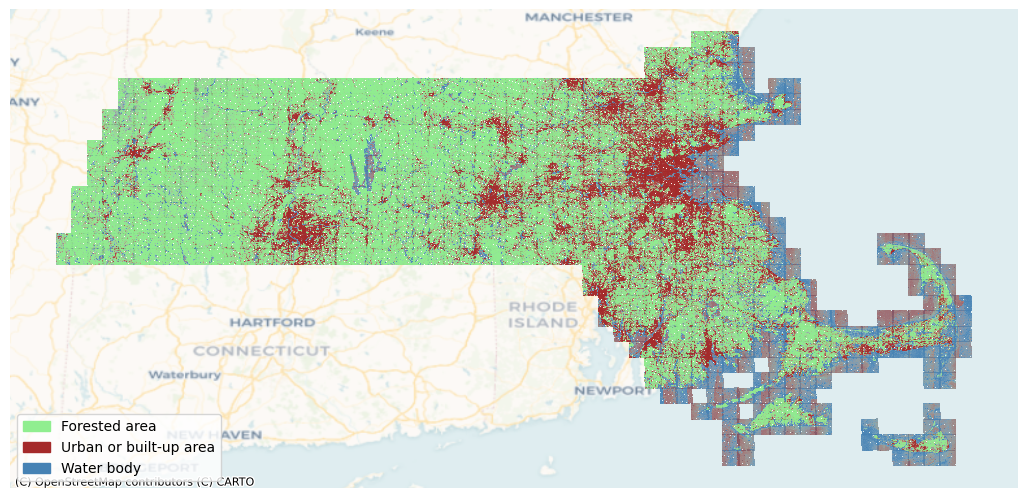

CPU times: user 1min 41s, sys: 544 ms, total: 1min 41s
Wall time: 1min 41s


In [100]:
%%time
plt.close('all')
fig, ax = plt.subplots(figsize=(13, 8))
windows_df_400.plot(ax=ax, color='lightgreen', alpha=chip_class_scores_normalized[:, 0])
windows_df_400.plot(ax=ax, color='brown', alpha=chip_class_scores_normalized[:, 1])
windows_df_400.plot(ax=ax, color='steelblue', alpha=chip_class_scores_normalized[:, 2])
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager, alpha=0.75)
legend_patches = [
    patches.Patch(color='lightgreen', alpha=1, label=classes[0]),
    patches.Patch(color='brown', alpha=1, label=classes[1]),
    patches.Patch(color='steelblue', alpha=1, label=classes[2]),
]
ax.legend(handles=legend_patches, loc='lower left')
ax.axis('off')
plt.show()

# Land cover map from H3 embeddings and H3 geometries

## Get H3 tiles for AOI

In [101]:
df = gpd.read_file('data/us-states.json')
df_aoi = df[df.name == 'Massachusetts']

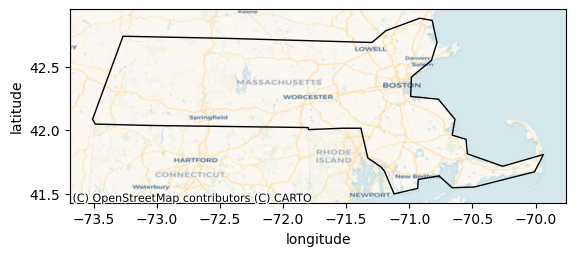

In [102]:
fig, ax = plt.subplots()

df_aoi.plot(ax=ax, ec='k', fc='none')
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.show()

In [103]:
ma_boundary = np.array(df_aoi.geometry.tolist()[0].exterior.coords)

In [302]:
resolution = 5
ma_h3_inds = list(h3.polyfill_polygon(ma_boundary, res=resolution))
ma_hexes = [h3.h3_to_geo_boundary(h3_idx) for h3_idx in ma_h3_inds]
ma_hexes = [Polygon(h_points) for h_points in ma_hexes]
len(ma_hexes)

35

In [303]:
h3_df = gpd.GeoDataFrame(dict(h3_index=ma_h3_inds), geometry=ma_hexes)
h3_df

,h3_index,geometry
0,85e72283fffffff,"POLYGON ((-70.87354 42.85518, -70.79936 42.697..."
1,85e72043fffffff,"POLYGON ((-71.25775 42.57541, -71.18311 42.415..."
2,85e725bbfffffff,"POLYGON ((-73.02581 42.74714, -72.95057 42.569..."
3,85e72013fffffff,"POLYGON ((-71.71504 42.72617, -71.64034 42.561..."
4,85e722bbfffffff,"POLYGON ((-70.8815 42.05518, -70.80655 41.9003..."
5,85e7204bfffffff,"POLYGON ((-71.10569 42.52685, -71.03108 42.368..."
6,85e720b3fffffff,"POLYGON ((-72.10256 42.42946, -72.02739 42.262..."
7,85e72503fffffff,"POLYGON ((-72.71739 42.63734, -72.64216 42.462..."
8,85e72247fffffff,"POLYGON ((-70.27555 41.88611, -70.20075 41.736..."
9,85e72543fffffff,"POLYGON ((-72.32727 42.93987, -72.2525 42.7683..."


## Spatial join with chip geometries

In [292]:
windows_df_400['geometry_chips'] = windows_df_400['geometry']

In [304]:
%%time
join_df = gpd.sjoin(h3_df, windows_df_400, how='left')
join_df = join_df.sort_values('h3_index')
len(join_df)

CPU times: user 309 ms, sys: 9 μs, total: 309 ms
Wall time: 308 ms


401902

In [305]:
%%time
join_df['ioa'] = join_df['geometry'].intersection(join_df['geometry_chips']).area / join_df['geometry'].area

CPU times: user 6.59 s, sys: 48 ms, total: 6.64 s
Wall time: 6.63 s


## Aggregate embeddings (via weighted sum) to H3 tile-level

In [306]:
%%time

embs_merged = torch.zeros(len(h3_df), 768)
i = 0

def agg_embeddings(df):
    assert df.index[0] == df.index[-1]
    if df['emb_idx'].isna().any():
        emb = torch.zeros(768)
    else:
        hex_embs = embs_400[df['emb_idx'].to_numpy()]
        weighted_hex_embs = hex_embs * df['ioa'].to_numpy()[:, None]
        emb = weighted_hex_embs.sum(dim=0)
    global i
    embs_merged[i] = emb
    i += 1

join_df.groupby(['h3_index']).apply(agg_embeddings)

CPU times: user 5.06 s, sys: 3.13 ms, total: 5.07 s
Wall time: 633 ms


""


In [307]:
embs_merged = F.normalize(embs_merged, dim=1)
embs_merged.shape

torch.Size([35, 768])

In [259]:
classes = [
    'Forested area', 
    'Urban or built-up area', 
    'Water body',
]

In [308]:
text_emb = get_text_emb(classes)
hex_class_scores = embs_merged @ text_emb.T
hex_class_scores_normalized = torch.softmax(hex_class_scores * 100, dim=1)

In [ ]:
hex_class_scores_normalized

In [310]:
gdf_h3 = gpd.GeoDataFrame(join_df.groupby(['h3_index', 'geometry']).size().reset_index())
assert len(gdf_h3) == len(hex_class_scores_normalized)

### resolution = 5

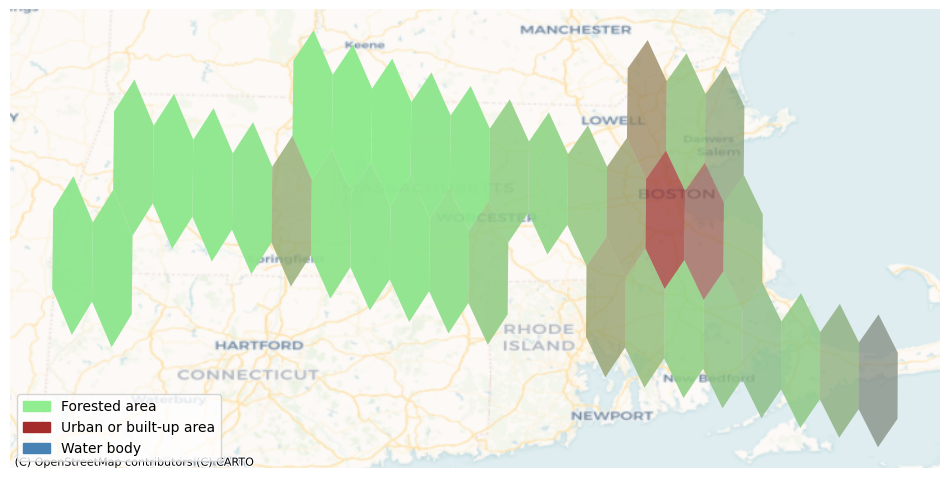

CPU times: user 392 ms, sys: 7.92 ms, total: 400 ms
Wall time: 1.1 s


In [312]:
%%time
plt.close('all')
fig, ax = plt.subplots(figsize=(12, 8))
gdf_h3.plot(ax=ax, color='lightgreen', alpha=hex_class_scores_normalized[:, 0])
gdf_h3.plot(ax=ax, color='brown', alpha=hex_class_scores_normalized[:, 1])
gdf_h3.plot(ax=ax, color='steelblue', alpha=hex_class_scores_normalized[:, 2])
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager, alpha=0.75)
legend_patches = [
    patches.Patch(color='lightgreen', alpha=1, label=classes[0]),
    patches.Patch(color='brown', alpha=1, label=classes[1]),
    patches.Patch(color='steelblue', alpha=1, label=classes[2]),
]
ax.legend(handles=legend_patches, loc='lower left')
ax.axis('off')
plt.show()

### resolution = 6

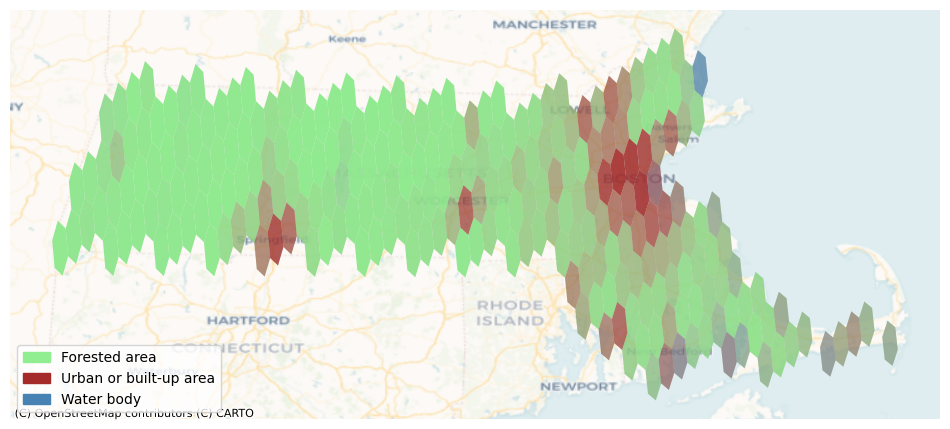

CPU times: user 264 ms, sys: 12 ms, total: 276 ms
Wall time: 274 ms


In [301]:
%%time
plt.close('all')
fig, ax = plt.subplots(figsize=(12, 8))
gdf_h3.plot(ax=ax, color='lightgreen', alpha=hex_class_scores_normalized[:, 0])
gdf_h3.plot(ax=ax, color='brown', alpha=hex_class_scores_normalized[:, 1])
gdf_h3.plot(ax=ax, color='steelblue', alpha=hex_class_scores_normalized[:, 2])
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager, alpha=0.75)
legend_patches = [
    patches.Patch(color='lightgreen', alpha=1, label=classes[0]),
    patches.Patch(color='brown', alpha=1, label=classes[1]),
    patches.Patch(color='steelblue', alpha=1, label=classes[2]),
]
ax.legend(handles=legend_patches, loc='lower left')
ax.axis('off')
plt.show()

### resolution = 7

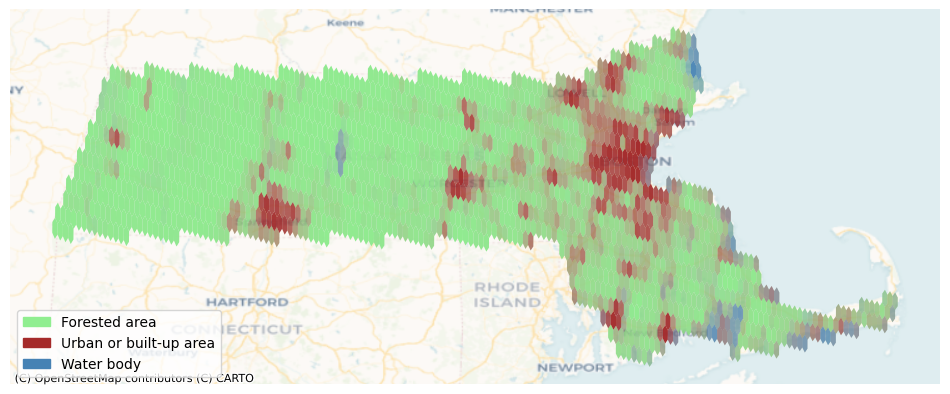

CPU times: user 466 ms, sys: 4.02 ms, total: 470 ms
Wall time: 469 ms


In [289]:
%%time
plt.close('all')
fig, ax = plt.subplots(figsize=(12, 8))
gdf_h3.plot(ax=ax, color='lightgreen', alpha=hex_class_scores_normalized[:, 0])
gdf_h3.plot(ax=ax, color='brown', alpha=hex_class_scores_normalized[:, 1])
gdf_h3.plot(ax=ax, color='steelblue', alpha=hex_class_scores_normalized[:, 2])
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager, alpha=0.75)
legend_patches = [
    patches.Patch(color='lightgreen', alpha=1, label=classes[0]),
    patches.Patch(color='brown', alpha=1, label=classes[1]),
    patches.Patch(color='steelblue', alpha=1, label=classes[2]),
]
ax.legend(handles=legend_patches, loc='lower left')
ax.axis('off')
plt.show()

### resolution = 8

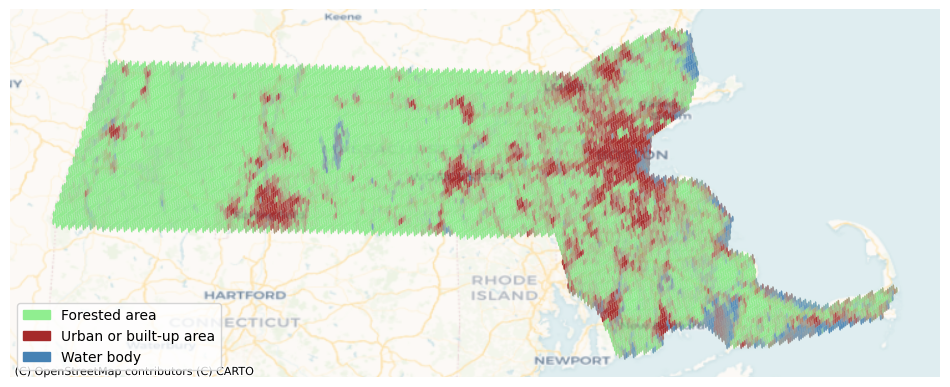

CPU times: user 2.11 s, sys: 16 ms, total: 2.13 s
Wall time: 2.13 s


In [277]:
%%time
plt.close('all')
fig, ax = plt.subplots(figsize=(12, 8))
gdf_h3.plot(ax=ax, color='lightgreen', alpha=hex_class_scores_normalized[:, 0])
gdf_h3.plot(ax=ax, color='brown', alpha=hex_class_scores_normalized[:, 1])
gdf_h3.plot(ax=ax, color='steelblue', alpha=hex_class_scores_normalized[:, 2])
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager, alpha=0.75)
legend_patches = [
    patches.Patch(color='lightgreen', alpha=1, label=classes[0]),
    patches.Patch(color='brown', alpha=1, label=classes[1]),
    patches.Patch(color='steelblue', alpha=1, label=classes[2]),
]
ax.legend(handles=legend_patches, loc='lower left')
ax.axis('off')
plt.show()

### resolution = 9

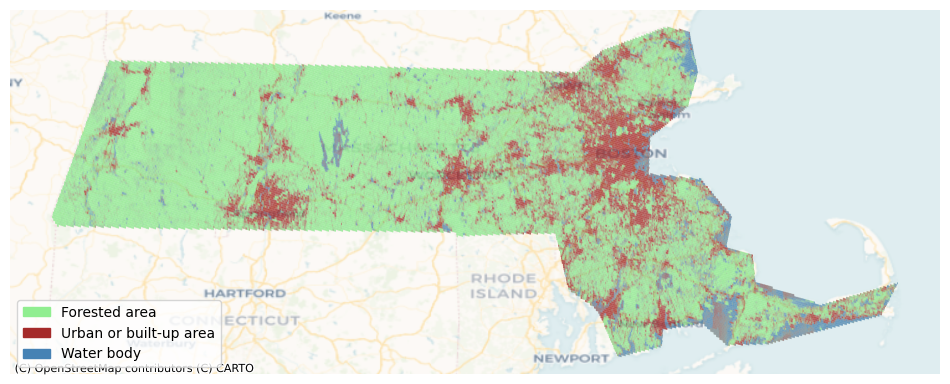

CPU times: user 15.1 s, sys: 12 ms, total: 15.1 s
Wall time: 15.1 s


In [252]:
%%time
plt.close('all')
fig, ax = plt.subplots(figsize=(12, 8))
gdf_h3.plot(ax=ax, color='lightgreen', alpha=hex_class_scores_normalized[:, 0])
gdf_h3.plot(ax=ax, color='brown', alpha=hex_class_scores_normalized[:, 1])
gdf_h3.plot(ax=ax, color='steelblue', alpha=hex_class_scores_normalized[:, 2])
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager, alpha=0.75)
legend_patches = [
    patches.Patch(color='lightgreen', alpha=1, label=classes[0]),
    patches.Patch(color='brown', alpha=1, label=classes[1]),
    patches.Patch(color='steelblue', alpha=1, label=classes[2]),
]
ax.legend(handles=legend_patches, loc='lower left')
ax.axis('off')
plt.show()

### resolution = 10

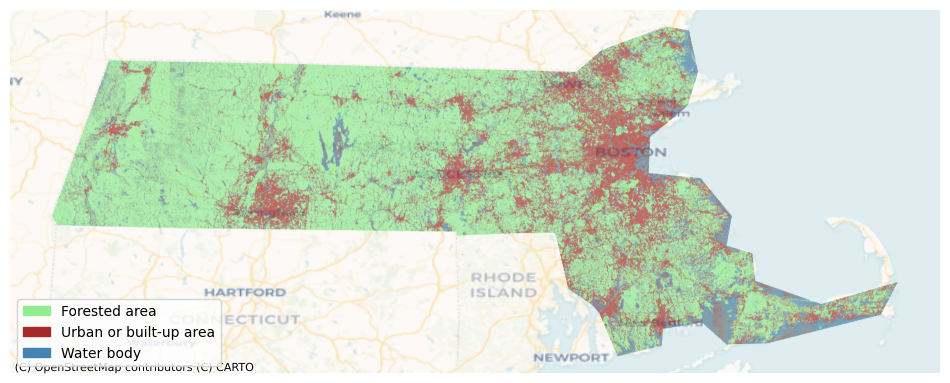

CPU times: user 1min 39s, sys: 740 ms, total: 1min 40s
Wall time: 1min 40s


In [264]:
%%time
plt.close('all')
fig, ax = plt.subplots(figsize=(12, 8))
gdf_h3.plot(ax=ax, color='lightgreen', alpha=hex_class_scores_normalized[:, 0])
gdf_h3.plot(ax=ax, color='brown', alpha=hex_class_scores_normalized[:, 1])
gdf_h3.plot(ax=ax, color='steelblue', alpha=hex_class_scores_normalized[:, 2])
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager, alpha=0.75)
legend_patches = [
    patches.Patch(color='lightgreen', alpha=1, label=classes[0]),
    patches.Patch(color='brown', alpha=1, label=classes[1]),
    patches.Patch(color='steelblue', alpha=1, label=classes[2]),
]
ax.legend(handles=legend_patches, loc='lower left')
ax.axis('off')
plt.show()